# Práctica 8: Residual neural networks - Parte 1


### Pre-requisitos. Instalar paquetes

Para la primera parte de este Laboratorio 7 necesitaremos TensorFlow y TensorFlow-Datasets. Además, como habitualmente, fijaremos la semilla aleatoria para asegurar la reproducibilidad de los experimentos.

In [135]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Fijamos la semilla para poder reproducir los resultados
import os
import numpy as np
import random
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

Además, cargamos también APIs que vamos a emplear para que el código quede más legible

In [136]:
#API de Keras, modelo Sequential y la capa Dense 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#Para mostrar gráficas
from matplotlib import pyplot

### Carga del conjunto de datos

Vamos a emplear el conjunto *german_credit_numeric*.


In [137]:
# TODO: Carga el conjunto german_credit como ds_train
# Indica además un tamaño de batch de 128 y que se repita indefinidamente
ds_train = tfds.load('german_credit_numeric', split='train',as_supervised=True).batch(128).repeat()

## Visualización del desvanecimiento del gradiente
Las Residual neural networks se ocupan de que los gradientes no se desvanezcan cuando la red es muy profunda. Vamos a visualizar este problema creando una red profunda y mostrando las dimensiones de los gradientes que llegan a cada capa.

Para ello debemos registrar las dimensiones de los gradientes a lo largo de entrenamiento. Crearemos un nuevo tipo de modelo, que va registrando los gradientes a medida que es entrenado. Nuestra nueva clase heredará de `tf.keras.models.Sequential`.

In [138]:
class GradientLoggingSequentialModel(tf.keras.models.Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # En la inicialización instanciamos una nueva variable en la que
        # registraremos el historial de tamaños de gradientes de cada capa
        self.gradient_history = {}
    
    def compile(self, **kwargs):
        result = super().compile(**kwargs)
        # Una vez sabemos la arquitectura, podemos inicializar la historia
        # de gradientes de cada capa a una lista vacía.
        for l in self.layers:
            self.gradient_history[l.name] = []
        return result
        
    def _save_gradients(self, gradients):
        # A cada paso de entrenamiento llamaremos a esta función para que
        # registre los gradientes.
        # En la lista gradients se encuentran los gradientes de las distintas
        # capas por orden. Cada capa l tendrá un número de gradientes que
        # concidirá con l.trainable_variables.
        # Teniendo esto en cuenta, recorremos los gradientes, calculamos su
        # tamaño y guardamos la media de tamaños de cada capa en el histórico
        i = 0
        for layer in self.layers:
            gradient_sizes = []
            for lw in layer.trainable_variables:
                g_size = np.linalg.norm(gradients[i].numpy())
                gradient_sizes.append(g_size)
                i += 1
            mean_gradient_size = np.mean(gradient_sizes)
            self.gradient_history[layer.name].append(mean_gradient_size)
        
    def train_step(self, data):
        # Haremos un paso de entrenamiento personalizado basado en 
        # https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#a_first_simple_example
        # Dejaremos el ejemplo tal cual, añadiendo tan solo la llamada a
        # _save_gradients una vez que disponemos de los gradientes
        
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        
        # Llamada añadida para grabar los gradientes.
        self._save_gradients(gradients)
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

### Creamos un modelo *GradientLoggingSequentialModel*
Creamos un modelo *Sequential* para ajustar a los datos de entrada siguiendo las especificaciones dadas.

In [139]:
# TODO - Define en model una red GradientLoggingSequentialModel con 20 capas ocultas, con activación sigmoide, con 10 unidades por capa.

# Definir las capas del modelo
layers = [tf.keras.layers.InputLayer(input_shape=(24,))]  # Especifica la forma de entrada
layers += [tf.keras.layers.Dense(10, activation="sigmoid") for _ in range(20)]
layers.append(tf.keras.layers.Dense(1, activation="softmax"))  # capa de salida

# Crear el modelo con las capas
model = GradientLoggingSequentialModel(layers=layers)

# Construimos el modelo y mostramos el resumen
model.build(input_shape=(None, 24))
print(model.summary())

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "gradient_logging_sequential_model_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_399 (Dense)               │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,351 (9.18 KB)

 Trainable params: 2,351 (9.18 KB)

 Non-trainable params: 0 (0.00 B)

None


### Entrenamiento del modelo
Vamos a establecer la función de pérdida (entropía cruzada binaria), el optimizador (SGD con LR $10^{-3}$) y la métrica que nos servirá para evaluar el rendimiento del modelo entrenado (área bajo la curva).

In [140]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


Entrenamos el modelo usando model.fit

In [141]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/10
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:615: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:590: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0000
Epoch 2/10
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000


Ahora que hemos hecho algunos pasos de entrenamiento, representamos el tamaño medio de los pesos de cada capa.

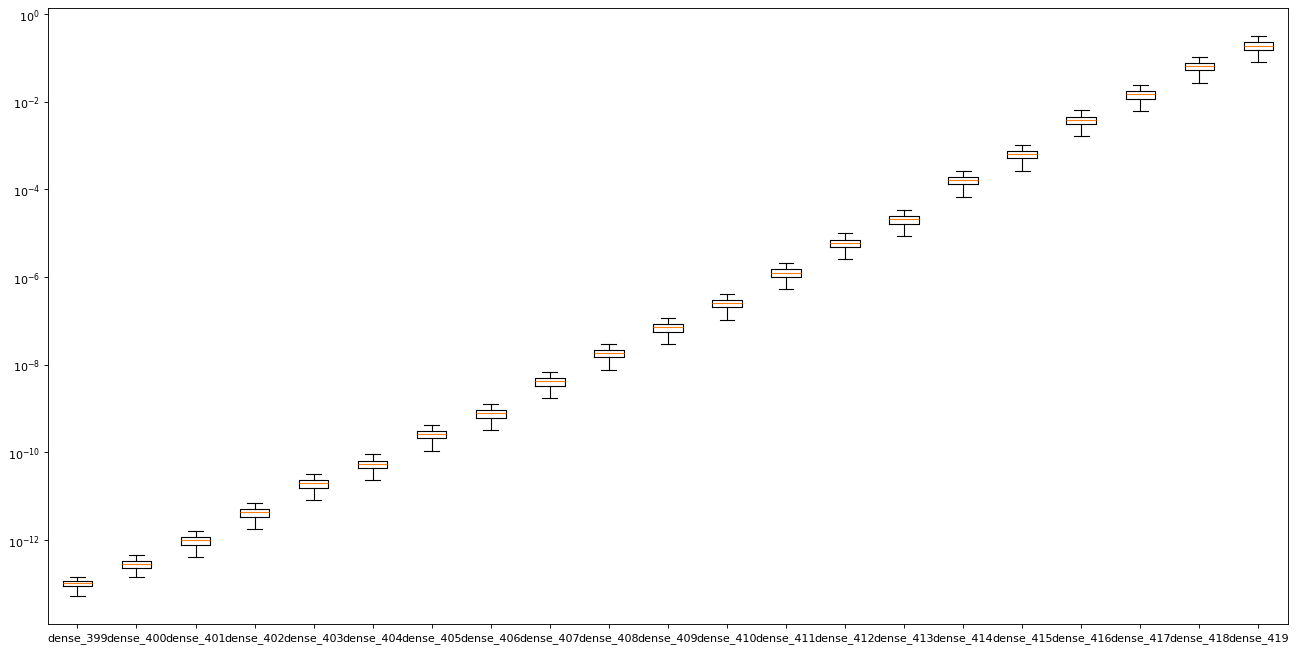

In [142]:
# Ahora accedemos al historial de gradientes y representamos el tamaño medio de los gradientes de cada capa.
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

# CAPAS CON RELU

In [143]:
# TODO - Define en model una red GradientLoggingSequentialModel con 20 capas ocultas, con activación sigmoide, con 10 unidades por capa.

# Definir las capas del modelo
layers = [tf.keras.layers.InputLayer(input_shape=(24,))]  # Especifica la forma de entrada
layers += [tf.keras.layers.Dense(10, activation="relu") for _ in range(18)]
layers.append(tf.keras.layers.Dense(1, activation="softmax"))  # capa de salida

# Crear el modelo con las capas
model = GradientLoggingSequentialModel(layers=layers)

# Construimos el modelo y mostramos el resumen
model.build(input_shape=(None, 24))
print(model.summary())

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "gradient_logging_sequential_model_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_427 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_432 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_434 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_435 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131 (8.32 KB)

 Trainable params: 2,131 (8.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [144]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


In [145]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/10


/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:615: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:590: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 2/10
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000


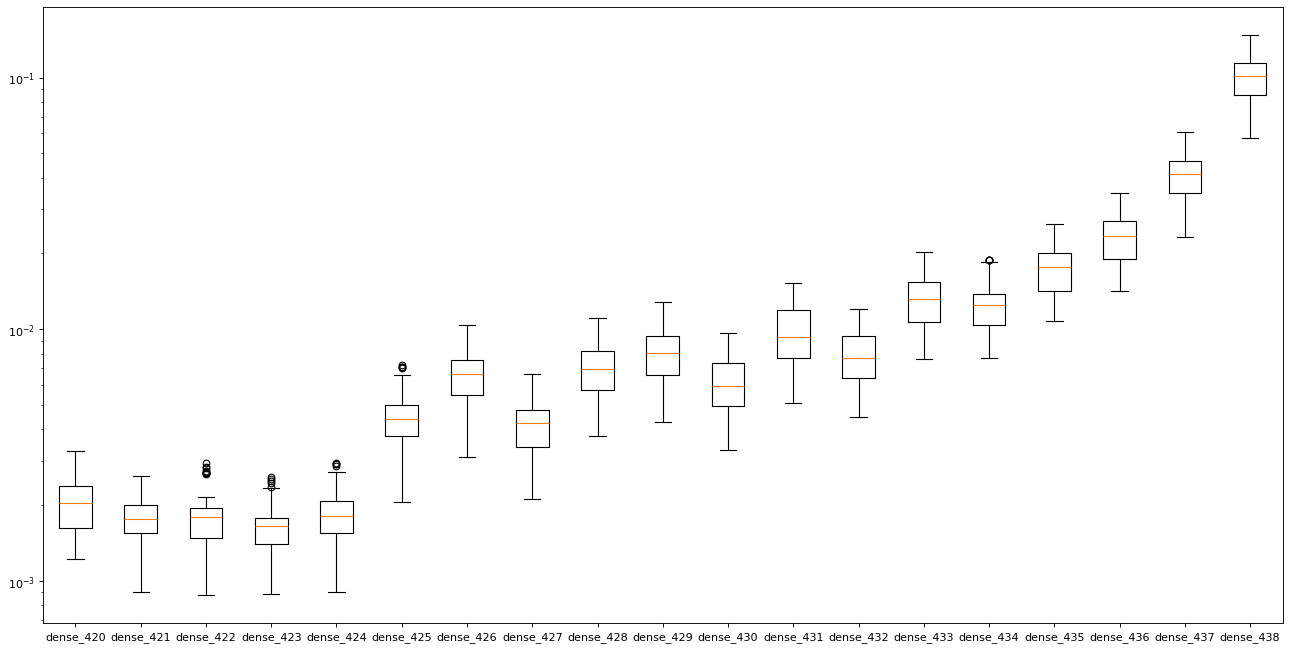

In [146]:
# Ahora accedemos al historial de gradientes y representamos el tamaño medio de los gradientes de cada capa.
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

# OTRAS FUNCIONES


In [147]:
# TODO - Define en model una red GradientLoggingSequentialModel con 20 capas ocultas, con activación sigmoide, con 10 unidades por capa.

# Definir las capas del modelo
layers = [tf.keras.layers.InputLayer(input_shape=(24,))]  # Especifica la forma de entrada
layers += [tf.keras.layers.Dense(10, activation="leaky_relu") for _ in range(18)]
layers.append(tf.keras.layers.Dense(1, activation="softmax"))  # capa de salida

# Crear el modelo con las capas
model = GradientLoggingSequentialModel(layers=layers)

# Construimos el modelo y mostramos el resumen
model.build(input_shape=(None, 24))
print(model.summary())

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "gradient_logging_sequential_model_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_439 (Dense)               │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_441 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_455 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131 (8.32 KB)

 Trainable params: 2,131 (8.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [148]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


In [149]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:615: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:590: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 2/10
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0000
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0000


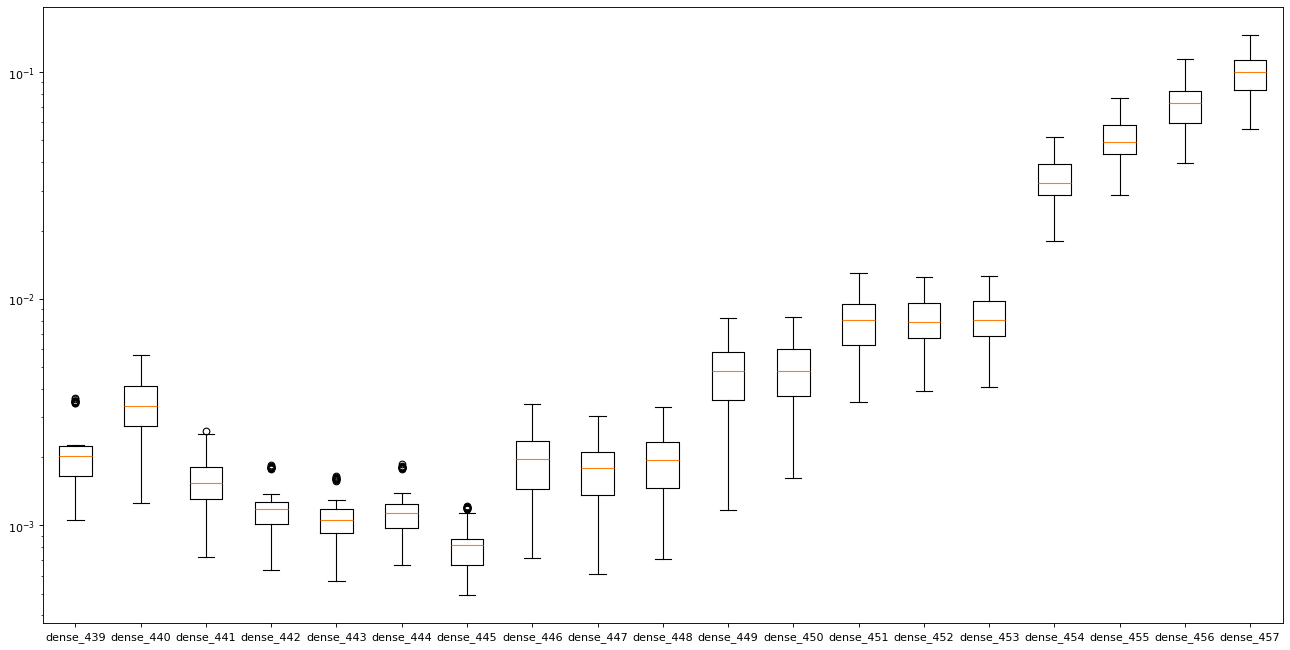

In [150]:
# Ahora accedemos al historial de gradientes y representamos el tamaño medio de los gradientes de cada capa.
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

# OTRO OPTIMIZADORES

In [151]:
#TODO - Compila el modelo. Utiliza la opción run_eagerly=True para que se puedan registrar los gradientes a cada paso

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              run_eagerly=True)


In [152]:
#TODO - entrenar el modelo utilizando 8 steps por epoch. Con 10 epochs nos valdrá para comprobar el desvanecimiento de gradientes.

num_epochs = 20

# Entrenamiento del modelo
history = model.fit(ds_train, epochs=num_epochs, steps_per_epoch=8)

Epoch 1/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:615: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:590: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.0000
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.0000

/home/clown/3-year/deep_learning/Deep-Learning/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0000
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 1.0000
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.0000
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0000
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.0000
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.0000
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0000
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0000
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 1.0000
Epoch 17/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms

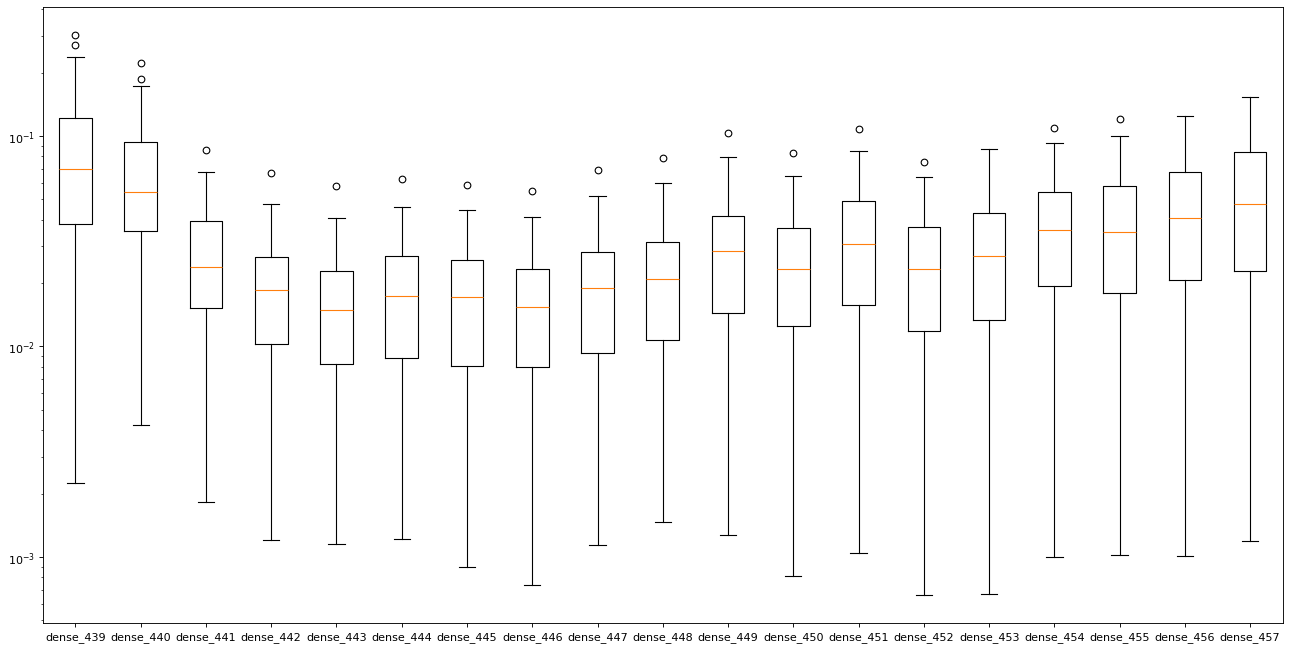

In [153]:
# Ahora accedemos al historial de gradientes y representamos el tamaño medio de los gradientes de cada capa.
pyplot.figure(figsize=(20, 10), dpi=80)
pyplot.boxplot(model.gradient_history.values())
pyplot.yscale('log')
pyplot.xticks(ticks=range(1,len(model.gradient_history)+1), labels=model.gradient_history.keys())
pyplot.show()

## Comparativa
 - ¿Qué observas en los pesos?

Siguen un aumento lineal conforme se profundiza en la red. Un valor del gradiente bajo al comienzo puede suponer que la red no este entrenando de forma efectiva, al no poder generalizar, ya que encuentra dificil ajustar los pesos correctamente.

 - ¿Ocurre lo mismo utilizando ReLU como función de activación de las capas ocultas?

No, al usar una funcion de activación más efectiva para este caso como es la __ReLU__, los gradientes comienzan en un mejor punto, casi el maximo que con la _Sigmoide_. Sin embargo observamos un pequeño descenso, que podriamos indentificar como un mínimo local. Aunque este mínimo no afecta al resultado final de la red.

 - Repite la prueba con las distintas [funciones de activación](https://keras.io/api/layers/activations/) que tengan sentido.

Al utilizar Leaky ReLU como función de activación, observamos una mejora significativa en el comportamiento de los gradientes. A diferencia de ReLU estándar, Leaky ReLU permite que fluyan gradientes incluso cuando la entrada es negativa, lo cual ayuda a evitar problemas de saturación y mantiene los gradientes en un rango más estable

 - (OPCIONAL) Alarga el entrenamiento y prueba distintos optimizadores para intentar que el modelo entrene correctamente.

Los gradientes se mantienen en un rango mucho más estable a lo largo de las capas, sin ningún patrón claro de desvanecimiento o explosión.